<a href="https://colab.research.google.com/github/saugatkandel/PtychoNN/blob/master/TF2/tf2_train_network_mixed_precision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Warning: this notebook is for Google Colab. 

In [ ]:
%tensorflow_version 2.x
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = '/content/drive/My Drive/PtychoNN/TF2/'
import sys
sys.path.append(path)
import keras_helper

### Choose GPU settings, import libraries

In [ ]:

#import os
#os.environ["CUDA_VISIBLE_DEVICES"]="0"
#num_GPU = len(os.environ["CUDA_VISIBLE_DEVICES"].split(',')) 

import tensorflow as tf

from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense
from tensorflow.keras import Sequential
from tensorflow.keras import Input
from tensorflow.keras import Model
from tensorflow.keras import mixed_precision

#config = tf.ConfigProto() 
#config.gpu_options.allow_growth=True 
#session = tf.Session(config=config)
#K.set_session(session)
mixed_precision.set_global_policy('mixed_float16')


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


In [ ]:
#print(os.environ["CUDA_VISIBLE_DEVICES"])
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if len(gpus):
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
      print("Restricting Memory")
  except RuntimeError as e:
    print(e)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Restricting Memory


In [ ]:
!nvidia-smi

Sun Jul 18 20:39:52 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import glob
from tqdm.notebook import tqdm as tqdm
# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

import keras_helper
import importlib
importlib.reload(keras_helper)
from keras_helper import *
from skimage.transform import resize

### Some training parameters

In [ ]:
h,w=64,64
nepochs=60
wt_path = 'wts4' #Where to store network weights
batch_size = 32

if (not os.path.isdir(path+wt_path)):
    os.mkdir(wt_path)

### Read experimental diffraction data and reconstructed images

In [ ]:
data_diffr = np.load(path+'../data/20191008_39_diff.npz')['arr_0']

In [ ]:
print(data_diffr.shape)
#plt.matshow(np.log10(data_diffr[0,0]))

data_diffr_red = np.zeros((data_diffr.shape[0],data_diffr.shape[1],64,64), float)
for i in tqdm(range(data_diffr.shape[0])):
    for j in range(data_diffr.shape[1]):
        data_diffr_red[i,j] = resize(data_diffr[i,j,32:-32,32:-32],(64,64),preserve_range=True, anti_aliasing=True)
        data_diffr_red[i,j] = np.where(data_diffr_red[i,j]<3,0,data_diffr_red[i,j])


(161, 161, 256, 256)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


In [ ]:
#amp = np.load('../expt_data/s26_data/20191008_30_10nm_amp.npz')['arr_0']
#ph = np.load('../expt_data/s26_data/20191008_39_10nm.npz')['arr_0']
real_space = np.load(path+'../data/20191008_39_amp_pha_10nm_full.npy')
amp = np.abs(real_space)
ph = np.angle(real_space)
amp.shape

(161, 161, 64, 64)

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


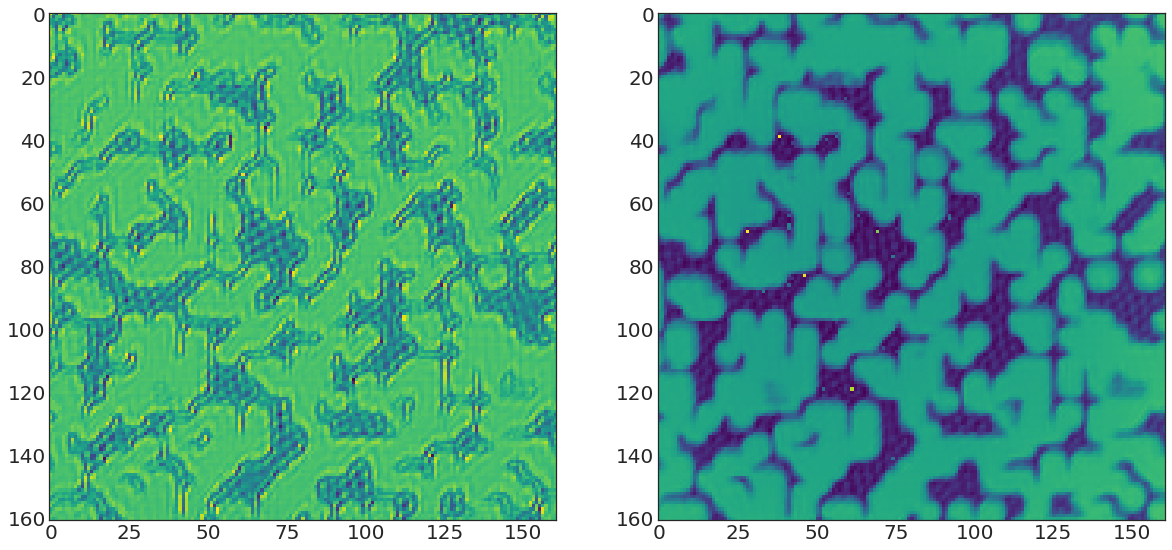

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(20,10))
ax[0].imshow(amp[:,:,32,32])
ax[1].imshow(ph[:,:,32,32])

### Split data and then shuffle

In [ ]:
nlines = 100 #How many lines of data to use for training?
nltest = 60 #How many lines for the test set?
tst_strt = amp.shape[0]-nltest #Where to index from
print(tst_strt)

101


In [ ]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split


X_train = data_diffr_red[:nlines,:].reshape(-1,h,w)[:,:,:,np.newaxis]
X_test = data_diffr_red[tst_strt:,tst_strt:].reshape(-1,h,w)[:,:,:,np.newaxis]
Y_I_train = amp[:nlines,:].reshape(-1,h,w)[:,:,:,np.newaxis]
Y_I_test = amp[tst_strt:,tst_strt:].reshape(-1,h,w)[:,:,:,np.newaxis]
Y_phi_train = ph[:nlines,:].reshape(-1,h,w)[:,:,:,np.newaxis]
Y_phi_test = ph[tst_strt:,tst_strt:].reshape(-1,h,w)[:,:,:,np.newaxis]

ntrain = X_train.shape[0]*X_train.shape[1]
ntest = X_test.shape[0]*X_test.shape[1]

print(X_train.shape, X_test.shape)

X_train, Y_I_train, Y_phi_train = shuffle(X_train, Y_I_train, Y_phi_train, random_state=0)

(16100, 64, 64, 1) (3600, 64, 64, 1)


### Save the test data for later use

In [ ]:
#np.save('data/X_test.npy', X_test) #Diffraction data
#np.save('data/Y_I_test.npy', Y_I_test) #Intensity data
#np.save('data/Y_phi_test.npy', Y_phi_test) #Intensity data

## Define the network structure

In [ ]:

tf.keras.backend.clear_session()
np.random.seed(123)

files=glob.glob('%s/*' %wt_path)
for file in files:
    os.remove(file)

    
input_img = Input(shape=(h, w, 1)) 

x = Conv_Pool_block(input_img,32,w1=3,w2=3,p1=2,p2=2, padding='same', data_format='channels_last')
x = Conv_Pool_block(x,64,w1=3,w2=3,p1=2,p2=2, padding='same', data_format='channels_last')
x = Conv_Pool_block(x,128,w1=3,w2=3,p1=2,p2=2, padding='same', data_format='channels_last')
#Activations are all ReLu

encoded=x

#Decoding arm 1
x1=Conv_Up_block(encoded,128,w1=3,w2=3,p1=2,p2=2,padding='same', data_format='channels_last')
x1=Conv_Up_block(x1,64,w1=3,w2=3,p1=2,p2=2,padding='same', data_format='channels_last')
x1=Conv_Up_block(x1,32,w1=3,w2=3,p1=2,p2=2,padding='same', data_format='channels_last')

decoded1 = Conv2D(1, (3, 3), padding='same')(x1)


#Decoding arm 2
x2=Conv_Up_block(encoded,128,w1=3,w2=3,p1=2,p2=2,padding='same', data_format='channels_last')
x2=Conv_Up_block(x2,64,w1=3,w2=3,p1=2,p2=2,padding='same', data_format='channels_last')
x2=Conv_Up_block(x2,32,w1=3,w2=3,p1=2,p2=2,padding='same', data_format='channels_last')

decoded2 = Conv2D(1, (3, 3), padding='same')(x2)

#Put together
autoencoder = Model(input_img, [decoded1, decoded2])

#parallel_model = ModelMGPU(autoencoder, gpus=num_GPU)
#parallel_model.compile(optimizer='adam', loss='mean_absolute_error')
autoencoder.compile(optimizer='adam', loss='mean_absolute_error')

print (autoencoder.summary())
#plot_model(autoencoder, to_file='paper_data/str_model.png')


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 32)   9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 32, 32, 32)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=2, min_lr=0.0001, verbose=1)

checkpoints= tf.keras.callbacks.ModelCheckpoint('%s/weights.{epoch:02d}.hdf5' %wt_path, 
                                            monitor='val_loss', verbose=1, save_best_only=True, 
                                            save_weights_only=False, mode='auto', period=1)

history=autoencoder.fit(X_train, [Y_I_train, Y_phi_train], shuffle=True, batch_size=batch_size, verbose=1, 
                           epochs=nepochs, validation_split = 0.05, callbacks=[checkpoints, reduce_lr])

Epoch 1/60
478/478 [==============================] - 46s 25ms/step - loss: 1.0538 - conv2d_12_loss: 0.1020 - conv2d_19_loss: 0.9518 - val_loss: 0.5129 - val_conv2d_12_loss: 0.0071 - val_conv2d_19_loss: 0.5058

Epoch 00001: val_loss improved from inf to 0.51291, saving model to wts4/weights.01.hdf5
Epoch 2/60
478/478 [==============================] - 11s 22ms/step - loss: 0.4615 - conv2d_12_loss: 0.0070 - conv2d_19_loss: 0.4546 - val_loss: 0.4139 - val_conv2d_12_loss: 0.0067 - val_conv2d_19_loss: 0.4072

Epoch 00002: val_loss improved from 0.51291 to 0.41392, saving model to wts4/weights.02.hdf5
Epoch 3/60
478/478 [==============================] - 10s 22ms/step - loss: 0.3954 - conv2d_12_loss: 0.0066 - conv2d_19_loss: 0.3888 - val_loss: 0.3661 - val_conv2d_12_loss: 0.0064 - val_conv2d_19_loss: 0.3597

Epoch 00003: val_loss improved from 0.41392 to 0.36609, saving model to wts4/weights.03.hdf5
Epoch 4/60
478/478 [==============================] - 10s 22ms/step - loss: 0.3565 - conv2d_

## Plot metrics of the training

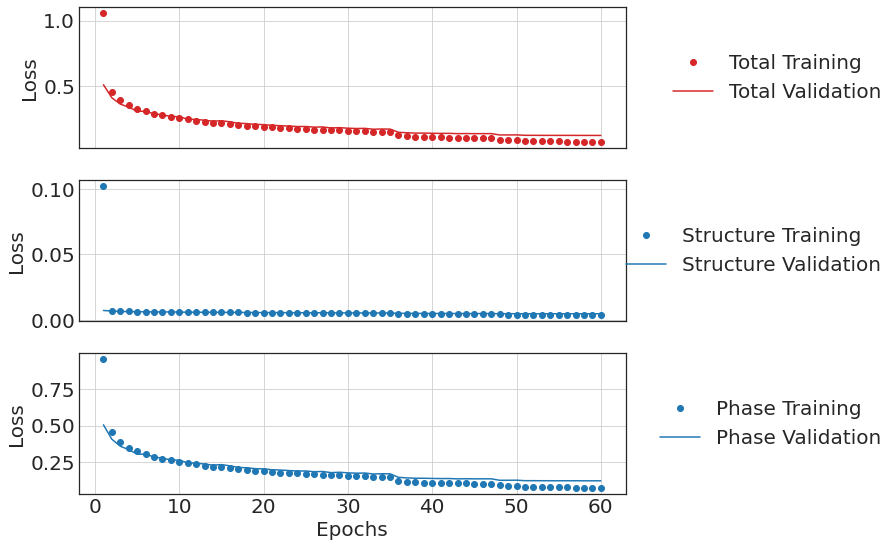

In [ ]:
hist=history
epochs=np.asarray(history.epoch)+1

%matplotlib inline
import matplotlib
plt.style.use('seaborn-white')
matplotlib.rc('font',family='Times New Roman')
matplotlib.rcParams['font.size'] = 20

f, axarr = plt.subplots(3, sharex=True, figsize=(12, 8))

axarr[0].set(ylabel='Loss')
axarr[0].plot(epochs,hist.history['loss'], 'C3o', label='Total Training')
axarr[0].plot(epochs,hist.history['val_loss'], 'C3-', label='Total Validation')
axarr[0].grid()
axarr[0].legend(loc='center right', bbox_to_anchor=(1.5, 0.5))

axarr[1].set(ylabel='Loss')
axarr[1].plot(epochs,hist.history['conv2d_12_loss'], 'C0o', label='Structure Training')
axarr[1].plot(epochs,hist.history['val_conv2d_12_loss'], 'C0-', label='Structure Validation')
axarr[1].legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
plt.xlabel('Epochs')
plt.tight_layout()
axarr[1].grid()


axarr[2].set(ylabel='Loss')
axarr[2].plot(epochs,hist.history['conv2d_19_loss'], 'C0o', label='Phase Training')
axarr[2].plot(epochs,hist.history['val_conv2d_19_loss'], 'C0-', label='Phase Validation')
axarr[2].legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
plt.tight_layout()
axarr[2].grid()


In [ ]:
np.save(path+'str_history', history.history)

### Save the epoch with the lowest validation loss
(PtychoNN will use these weights)

In [ ]:
val_losses=hist.history['val_loss']
min_epoch=np.argmin(val_losses)+1
print (min_epoch)
np.save(path+'%s/min_epoch' %(wt_path), min_epoch)

60
